In [3]:
import networkx as nx 
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt
from GraRep.GraRep import GraRep
from Node2Vec.Node2Vec import Node2Vec
from GraphWave.GraphWave import GraphWave
import math

np.random.seed(123)



In [2]:
def plot_networkx(graph, role_labels):
        cmap = plt.get_cmap('hot')
        x_range = np.linspace(0, 1, len(np.unique(role_labels)))
        coloring = {u: cmap(x_range[i]) for i, u in enumerate(np.unique(role_labels))}
        node_color = [coloring[role_labels[i]] for i in range(len(role_labels))]
        plt.figure()
        nx.draw_networkx(graph, pos=nx.layout.fruchterman_reingold_layout(graph),
                         node_color=node_color, cmap='hot')
        plt.show()
        return

In [3]:

def build_structure(width_basis, basis_type, list_shapes, start=0,
                    rdm_basis_plugins =False, add_random_edges=0,
                    plot=False, savefig=False):
    '''This function creates a basis (torus, string, or cycle)
    and attaches elements of the type in the list randomly along the basis.
    Possibility to add random edges afterwards.
    INPUT:
    --------------------------------------------------------------------------------------
    width_basis      :      width (in terms of number of nodes) of the basis
    basis_type       :      (torus, string, or cycle)
    shapes           :      list of shape list (1st arg: type of shape,
                            next args:args for building the shape,
                            except for the start)
    start            :      initial nb for the first node
    rdm_basis_plugins:      boolean. Should the shapes be randomly placed
                            along the basis (True) or regularly (False)?
    add_random_edges :      nb of edges to randomly add on the structure
    plot,savefig     :      plotting and saving parameters
    OUTPUT:
    --------------------------------------------------------------------------------------
    basis            :       a nx graph with the particular shape
    colors           :       labels for each role
    '''
    basis, role_id = eval(basis_type)(start, width_basis)
    n_basis, n_shapes = nx.number_of_nodes(basis), len(list_shapes)
    start += n_basis        # indicator of the id of the next node

    # Sample (with replacement) where to attach the new motives
    if rdm_basis_plugins is True:
        plugins = np.random.choice(n_basis, n_shapes, replace=False)
    else:
        spacing = math.floor(width_basis / n_shapes)
        plugins = [int(k * spacing) for k in range(n_shapes)]
    communities = [0] * n_basis
    seen_shapes = {'basis': [0, n_basis]}
    for p in plugins:
        role_id[p] += 1

    for shape_id, shape in enumerate(list_shapes):
        shape_type = shape[0]
        args = [start]
        if len(shape)>1:
            args += shape[1:]
        args += [0]
        graph_s, roles_graph_s = eval(shape_type)(*args)
        n_s = nx.number_of_nodes(graph_s)
        try:
            col_start = seen_shapes[shape_type][0]
        except:
            col_start = np.max(role_id) + 1
            seen_shapes[shape_type] = [col_start, n_s]
        # Attach the shape to the basis
        basis.add_nodes_from(graph_s.nodes())
        basis.add_edges_from(graph_s.edges())
        basis.add_edges_from([(start, plugins[shape_id])])
        role_id[plugins[shape_id]] += (-2 - 10 * seen_shapes[shape_type][0])
        communities += [shape_id] * n_s
        temp_labels = [r + col_start for r in roles_graph_s]
        temp_labels[0] += 100 * seen_shapes[shape_type][0]
        role_id += temp_labels
        start += n_s

    if add_random_edges > 0:
        # add random edges between nodes:
        for p in range(add_random_edges):
            src, dest = np.random.choice(nx.number_of_nodes(basis),
                                         2, replace=False)
            print(src, dest)
            basis.add_edges_from([(src, dest)])
    if plot is True: plot_networkx(basis, role_id)

    return basis, communities, plugins, role_id

In [4]:
def cycle(start, len_cycle, role_start=0, plot=False):
    '''Builds a cycle graph, with index of nodes starting at start
    and role_ids at role_start
    INPUT:
    -------------
    start       :    starting index for the shape
    role_start  :    starting index for the roles
    plot        :    boolean -- should the shape be printed?
    OUTPUT:
    -------------
    graph           :    a house shape graph, with ids beginning at start
    roles       :    list of the roles of the nodes (indexed starting at
                     role_start)
    '''
    graph = nx.Graph()
    graph.add_nodes_from(range(start, start + len_cycle))
    for i in range(len_cycle-1):
        graph.add_edges_from([(start + i, start + i + 1)])
    graph.add_edges_from([(start + len_cycle - 1, start)])
    roles = [role_start] * len_cycle
    if plot is True: plot_networkx(graph, roles)
    return graph, roles



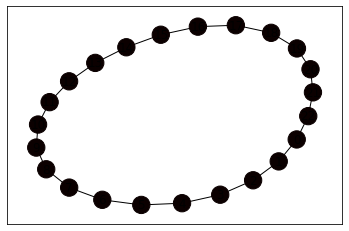

(<networkx.classes.graph.Graph at 0x21d8866a7c0>,
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [31]:
cycle(0,23,0,True)

In [5]:

def house(start, role_start=0, plot=False):
    '''Builds a house-like  graph, with index of nodes starting at start
    and role_ids at role_start
    INPUT:
    -------------
    start       :    starting index for the shape
    role_start  :    starting index for the roles
    plot        :    boolean -- should the shape be printed?
    OUTPUT:
    -------------
    graph           :    a house shape graph, with ids beginning at start
    roles       :    list of the roles of the nodes (indexed starting at
                     role_start)
    '''
    graph = nx.Graph()
    graph.add_nodes_from(range(start, start + 5))
    graph.add_edges_from([(start, start + 1), (start + 1, start + 2),
                          (start + 2, start + 3), (start + 3, start)])
    graph.add_edges_from([(start, start + 2), (start + 1, start + 3)])
    graph.add_edges_from([(start + 4, start), (start + 4, start + 1)])
    roles = [role_start, role_start, role_start + 1,
             role_start + 1, role_start + 2]
    if plot is True: plot_networkx(graph, roles)
    return graph, roles



In [56]:
G, role_id = house(1,1)

(<networkx.classes.graph.Graph at 0x21d883bb250>, [1, 1, 2, 2, 3])

In [52]:
nx.adjacency_matrix(G).todense()

C:\Users\grycz\AppData\Local\Temp\ipykernel_5192\2037155708.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  nx.adjacency_matrix(G).todense()


matrix([[0, 1, 1, 1, 1],
        [1, 0, 1, 1, 1],
        [1, 1, 0, 1, 0],
        [1, 1, 1, 0, 0],
        [1, 1, 0, 0, 0]], dtype=int32)

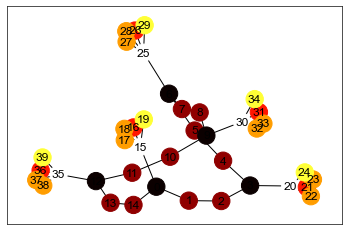

In [6]:
width_basis = 15
nbTrials = 20


################################### EXAMPLE TO BUILD A SIMPLE REGULAR STRUCTURE ##########
## REGULAR STRUCTURE: the most simple structure:  basis + n small patterns of a single type

### 1. Choose the basis (cycle, torus or chain)
basis_type = "cycle" 

### 2. Add the shapes 
n_shapes = 5  ## numbers of shapes to add 
#shape=["fan",6] ## shapes and their associated required parameters  (nb of edges for the star, etc)
#shape=["star",6]
list_shapes = [["house"]] * n_shapes

### 3. Give a name to the graph
identifier = 'AA'  ## just a name to distinguish between different trials
name_graph = 'houses'+ identifier
sb.set_style('white')

### 4. Pass all these parameters to the Graph Structure
add_edges = 0
G, communities, _ , role_id = build_structure(width_basis, basis_type, list_shapes, start=0,
                                       add_random_edges=add_edges, plot=True,
                                       savefig=False)

In [27]:
matrix = input("Give path to adjacency matrix: ")
GW = GraphWave(matrix, 25,1)
chi = GW.create_embedding(100,0,10)


In [100]:
matrix = input("Give path to adjacency matrix: ")
k = input("Give maximum transition step: ")
d = input("Give embedding dimension: ")
GR = GraRep(matrix, int(k), int(d))
chi2 = GR.create_embedding()

In [4]:
matrix = input("Give path to adjacency matrix: ")
le = int(input("Give length of a single random walk: "))
r = int(input("Give number of random walks starting at a single vertex: "))
p = float(input("Give bias Return parameter: "))
q = float(input("Give bias In-Out parameter: "))
d = int(input("Give embedding dimension: "))
NV = Node2Vec(matrix, int(le), int(r), int(p), int(q), int(d))
chi3 = NV.create_embedding()

TypeError: __init__() got an unexpected keyword argument 'size'

In [187]:
np.array(chi2).shape


(5, 40, 2)

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(chi2)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

In [72]:
len(role_id)

40

In [124]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [247]:
#df = pd.DataFrame(chi.transpose())
#df
df = pd.DataFrame(np.array(chi2[4]))
df

,0,1
0,-0.536908,7.149148e-15
1,-0.505740,1.473643e-01
2,-0.505740,3.917783e-01
3,-0.536908,5.770161e-01
4,-0.505740,4.828544e-01
5,-0.505740,3.894966e-01
6,-0.536908,3.566156e-01
7,-0.505740,1.510562e-01
8,-0.505740,-1.510562e-01
9,-0.536908,-3.566156e-01


In [248]:
X = df
Y = role_id

In [249]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size = 0.2)

In [250]:
model = LogisticRegression()
model.fit(X_train, Y_train)
model.score(X_test, Y_test)

0.5

In [251]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_pca.shape

(40, 2)

In [252]:
X_train_pca, X_test_pca, Y_train, Y_test = train_test_split(X_pca, Y, test_size = 0.2)

In [253]:
model = LogisticRegression()
model.fit(X_train_pca, Y_train)
model.score(X_test_pca, Y_test)

0.125

In [254]:
a,b = X_pca.transpose()

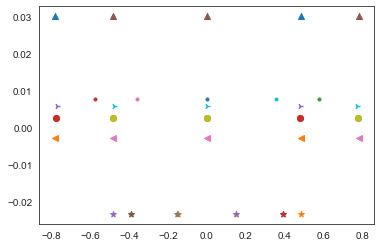

In [255]:
markers = {0:'*',-21: '.', 2:'<',3: 'o',4: '4',202: '^'}

for i in range(40):
    #plt.xlim(-0.15, 0.25)
    #plt.ylim(-0.025,0.025)
    plt.scatter(a[i],b[i],marker=markers[role_id[i]])
    #if i%4 == 0:
        #plt.show()
plt.show()